# Stabilisation
Ce script a pour but de stabiliser les photos, c'est à dire de mapper des points d'intérêts entre deux photos quasi identiques mais prises avec des angles un peu différents.
Ce processus a pour but d'augmenter la performance du réseau de neurones en appliquant cette transformation à toute photo en entrée du réseau.

##### Importation des librairies

In [1]:
import os
import cv2
import numpy as np
from random import choice
import matplotlib.pyplot as plt

##### Lecture des données

In [2]:
# Chemin vers les données
PATH_IMG = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/img/"
IMG_SIZE = 256

# la photo référence correspond à une photo du lieu de la queue sans personnes
photo_ref = "53921567_2296448580598357_4772525796268965888_n.jpg"

In [3]:
def load_random(path_img, img_size=256, img_ref_name=""):
    """
    Charge aléatoirement une image contenue dans le répertoires 'path_img'
    - img_size : change la taille de l'image
    """
    # random selection of one image
    while True:
        file = choice(os.listdir(path_img))
        if not os.path.isfile(os.path.join(path_img, file)) or file == img_ref_name:
            continue
        else:
            break
    
    img = cv2.imread(os.path.join(path_img, file), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size)).astype(np.float32)
    return img

In [4]:
def load_img(path_img, photo_ref, img_size=256):
    """
    Charge l'image de référence ainsi qu'une autre image aléatoire
    """
    # Lecture de l'image de référence
    img_ref = cv2.imread(os.path.join(path_img, photo_ref), cv2.IMREAD_COLOR)
    img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)
    img_ref = cv2.resize(img_ref, (IMG_SIZE, IMG_SIZE)).astype(np.float32)

    # Lecture d'une image aléatoire
    img = load_random(path_img, img_size=img_size, img_ref_name=photo_ref)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_ref.astype(np.uint8), interpolation='nearest')
    plt.title('image de référence')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img.astype(np.uint8), interpolation='nearest')
    plt.title('image aléatoire')
    plt.axis('off')
    plt.show()
    return img_ref, img

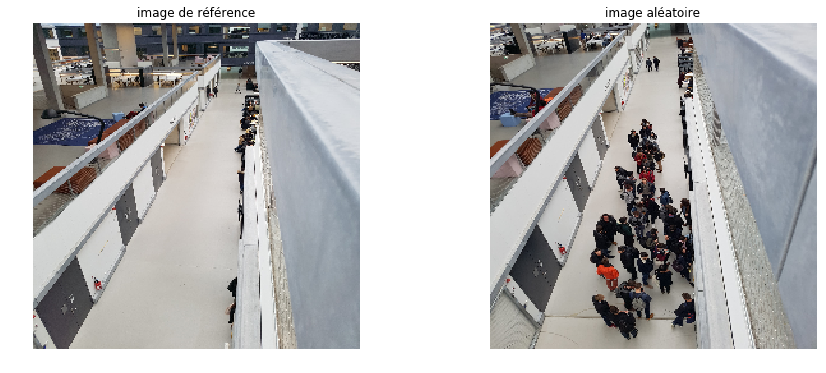

In [5]:
img_ref, img = load_img(PATH_IMG, photo_ref, img_size=IMG_SIZE)

In [6]:
def get_interest_point(img, display=False):
    """
    Renvoie les points d'intérêts d'une image
    """
    features = cv2.goodFeaturesToTrack(img, maxCorners=100, qualityLevel=0.01, minDistance=20)
    
    x = list()
    y = list()
    for interest in features:
        x.append(interest[0][0])
        y.append(interest[0][1])

    if display:
        plt.figure(figsize=(15, 6))
        plt.imshow(img.astype(np.uint8))
        plt.scatter(x, y, c='b')
        plt.axis('off')
        plt.title("points d'intérêts de la photo")
        plt.show()
    return x, y

In [88]:
# convert 2 gray
img_ref_gray = cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY)
img_ref_gray = img_ref_gray.astype(np.uint8)
# find features
prev_pts = cv2.goodFeaturesToTrack(img_ref_gray, 200, 0.01, 30)

In [89]:
# convert 2 gray
img_gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
img_gray = img_gray.astype(np.uint8)
# find transformation
curr_pts, status, err = cv2.calcOpticalFlowPyrLK(img_ref_gray, img_gray, prev_pts, None)

In [90]:
# Filter only valid points
idx = np.where(status==1)[0]
prev_pts = prev_pts[idx]
curr_pts = curr_pts[idx]

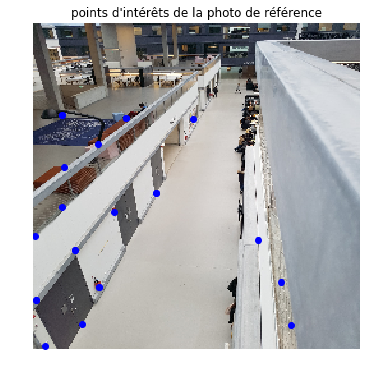

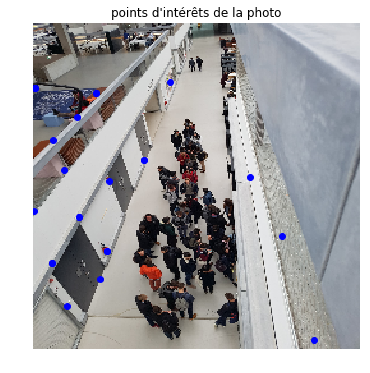

In [93]:
x = list()
y = list()
for interest in prev_pts:
    x.append(interest[0][0])
    y.append(interest[0][1])

if display:
    plt.figure(figsize=(15, 6))
    plt.imshow(img_ref.astype(np.uint8))
    plt.scatter(x, y, c='b')
    plt.axis('off')
    plt.title("points d'intérêts de la photo de référence")
    plt.show()
    
x = list()
y = list()
for interest in curr_pts:
    x.append(interest[0][0])
    y.append(interest[0][1])

if display:
    plt.figure(figsize=(15, 6))
    plt.imshow(img.astype(np.uint8))
    plt.scatter(x, y, c='b')
    plt.axis('off')
    plt.title("points d'intérêts de la photo")
    plt.show()

In [91]:
transform = cv2.estimateAffine2D(prev_pts, curr_pts, False)

In [92]:
transform[0]

array([[ 9.67887602e-01,  2.15513998e-01, -3.54530419e+01],
       [-4.05457835e-03,  9.40492171e-01, -1.57670429e+01]])

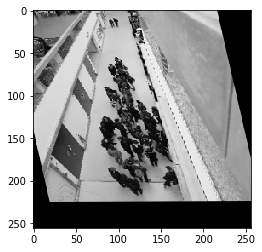

In [86]:
test = cv2.warpAffine(img_gray, transform[0], dsize=(256, 256))
plt.imshow(test, cmap='gray')

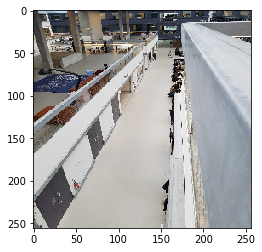

In [79]:
plt.imshow(img_ref.astype(np.uint8))

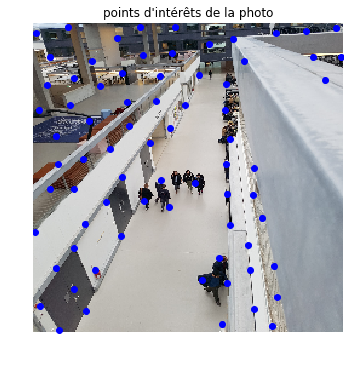

In [14]:
x_int, y_int = get_interest_point(img, display=True)

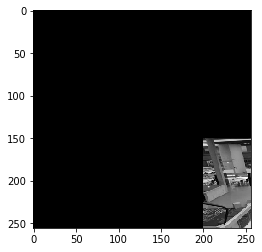

In [9]:
img_ref_gray = cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

rows,cols = img_gray.shape
M = np.float32([[1,0,200],[0,1,150]])
dst = cv2.warpAffine(img_gray,M,(cols,rows))
plt.imshow(dst.astype(np.uint8), cmap='gray')

In [12]:
# Initiate SIFT detector
orb = cv2.ORB_create() 

# find the keypoints and descriptors with SIFT
kp = orb.detect(img_ref_gray, None)

error: OpenCV(4.0.1) /io/opencv/modules/imgproc/src/color.hpp:259: error: (-2:Unspecified error) in function 'cv::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::Set<3, 4>; VDcn = cv::Set<1>; VDepth = cv::Set<0, 2, 5>; cv::SizePolicy sizePolicy = (cv::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [13]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img_ref_gray, None)
test = cv2.drawKeypoints(img_ref_gray,kp,img)

error: OpenCV(4.0.1) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


In [31]:
def find_random_pair(corners_left, corners_right):
    #Random choice of corners
    x_left = choice(corners_left)
    x_right = choice(corners_left)
    return x_left, x_right

def find_translation_vector(c_left, c_right):
    #We compute the translation between the two corners
    x_trans = c_right[0] - c_left[0]
    y_trans = c_right[1] - c_left[1]
    return int(x_trans), int(y_trans)

def compute_error(x_trans, y_trans, left_img, right_img, threshold=2):
    # There are multiple possibilities for the translation.
    # Each one will result in a a different position for the second image
    if x_trans > 0 and y_trans > 0:
        right_overlap = right_img[:-x_trans, :-y_trans]
        left_overlap = left_img[x_trans:, y_trans:]
    elif x_trans < 0 and y_trans > 0:
        right_overlap = right_img[-x_trans:, :-y_trans]
        left_overlap = left_img[:x_trans, y_trans:]
    elif x_trans > 0 and y_trans < 0:
        right_overlap = right_img[:-x_trans, -y_trans:]
        left_overlap = left_img[x_trans:, :y_trans]
    elif x_trans < 0 and y_trans < 0:
        right_overlap = right_img[-x_trans:, -y_trans:]
        left_overlap = left_img[:x_trans, :y_trans]
    else:
        # no translation or only in one direction
        left_overlap = left_img.copy()
        right_overlap = right_img.copy()
    ssd = np.square(left_overlap - right_overlap)
    error = np.sum(ssd < threshold) 
    # The error is the actually the number of overlapping points (given a threshold)
    return error

In [43]:
def stitch_images(left_img, right_img, max_tries=1000):
    
    # Transform to gray
    left_img = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
    
    # Find corner points
    corners_left  = get_interest_point(left_img, display=False)
    corners_right = get_interest_point(right_img, display=False)
    # the number of overlapping points will be positive
    best_error = -10
    best_trans = None
    
    for n_try in range(max_tries):
        if n_try % 10 == 0:
            print("Essai {} / {}".format(n_try, max_tries))
        
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)
        
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Compute resulting error. 
        this_error  = compute_error(x_trans, y_trans, left_img, right_img)
        # We try to maximize the number of overlapping points
        if this_error > best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
    print('Best transformation : {}'.format(best_trans))
    left_width, left_height = left_img.shape
    right_width, right_height = right_img.shape
    stitched_image = np.zeros((left_width + abs(best_trans[0]), left_height + abs(best_trans[1])))
    # Given the translation, we decide how we will stich the images (which direction)
    if best_trans[0] > 0 and best_trans[1] > 0:
        stitched_image[:left_width, :left_height] = left_img
        stitched_image[best_trans[0]:right_width + best_trans[0], best_trans[1]:right_height + best_trans[1]] = right_img
    elif best_trans[0] < 0 and best_trans[1] < 0:
        stitched_image[-best_trans[0]:left_width - best_trans[0], -best_trans[1]:left_height - best_trans[1]] = left_img
        stitched_image[:right_width, :right_height] = right_img
    elif best_trans[0] > 0 and best_trans[1] < 0:
        stitched_image[:left_width, - best_trans[1]:left_height - best_trans[1]] = left_img
        stitched_image[best_trans[0]:right_width + best_trans[0], :right_height] = right_img
    elif best_trans[0] < 0 and best_trans[1] > 0:
        stitched_image[-best_trans[0]:left_width - best_trans[0], :left_height] = left_img
        stitched_image[:right_width, best_trans[1]:right_height + best_trans[1]] = right_img
    return stitched_image

Essai 0 / 100000
Essai 10 / 100000
Essai 20 / 100000
Essai 30 / 100000
Essai 40 / 100000
Essai 50 / 100000
Essai 60 / 100000
Essai 70 / 100000
Essai 80 / 100000
Essai 90 / 100000
Essai 100 / 100000
Essai 110 / 100000
Essai 120 / 100000
Essai 130 / 100000
Essai 140 / 100000
Essai 150 / 100000
Essai 160 / 100000
Essai 170 / 100000
Essai 180 / 100000
Essai 190 / 100000
Essai 200 / 100000
Essai 210 / 100000
Essai 220 / 100000
Essai 230 / 100000
Essai 240 / 100000
Essai 250 / 100000
Essai 260 / 100000
Essai 270 / 100000
Essai 280 / 100000
Essai 290 / 100000
Essai 300 / 100000
Essai 310 / 100000
Essai 320 / 100000
Essai 330 / 100000
Essai 340 / 100000
Essai 350 / 100000
Essai 360 / 100000
Essai 370 / 100000
Essai 380 / 100000
Essai 390 / 100000
Essai 400 / 100000
Essai 410 / 100000
Essai 420 / 100000
Essai 430 / 100000
Essai 440 / 100000
Essai 450 / 100000
Essai 460 / 100000
Essai 470 / 100000
Essai 480 / 100000
Essai 490 / 100000
Essai 500 / 100000
Essai 510 / 100000
Essai 520 / 100000
Essa

Essai 5480 / 100000
Essai 5490 / 100000
Essai 5500 / 100000
Essai 5510 / 100000
Essai 5520 / 100000
Essai 5530 / 100000
Essai 5540 / 100000
Essai 5550 / 100000
Essai 5560 / 100000
Essai 5570 / 100000
Essai 5580 / 100000
Essai 5590 / 100000
Essai 5600 / 100000
Essai 5610 / 100000
Essai 5620 / 100000
Essai 5630 / 100000
Essai 5640 / 100000
Essai 5650 / 100000
Essai 5660 / 100000
Essai 5670 / 100000
Essai 5680 / 100000
Essai 5690 / 100000
Essai 5700 / 100000
Essai 5710 / 100000
Essai 5720 / 100000
Essai 5730 / 100000
Essai 5740 / 100000
Essai 5750 / 100000
Essai 5760 / 100000
Essai 5770 / 100000
Essai 5780 / 100000
Essai 5790 / 100000
Essai 5800 / 100000
Essai 5810 / 100000
Essai 5820 / 100000
Essai 5830 / 100000
Essai 5840 / 100000
Essai 5850 / 100000
Essai 5860 / 100000
Essai 5870 / 100000
Essai 5880 / 100000
Essai 5890 / 100000
Essai 5900 / 100000
Essai 5910 / 100000
Essai 5920 / 100000
Essai 5930 / 100000
Essai 5940 / 100000
Essai 5950 / 100000
Essai 5960 / 100000
Essai 5970 / 100000


Essai 10500 / 100000
Essai 10510 / 100000
Essai 10520 / 100000
Essai 10530 / 100000
Essai 10540 / 100000
Essai 10550 / 100000
Essai 10560 / 100000
Essai 10570 / 100000
Essai 10580 / 100000
Essai 10590 / 100000
Essai 10600 / 100000
Essai 10610 / 100000
Essai 10620 / 100000
Essai 10630 / 100000
Essai 10640 / 100000
Essai 10650 / 100000
Essai 10660 / 100000
Essai 10670 / 100000
Essai 10680 / 100000
Essai 10690 / 100000
Essai 10700 / 100000
Essai 10710 / 100000
Essai 10720 / 100000
Essai 10730 / 100000
Essai 10740 / 100000
Essai 10750 / 100000
Essai 10760 / 100000
Essai 10770 / 100000
Essai 10780 / 100000
Essai 10790 / 100000
Essai 10800 / 100000
Essai 10810 / 100000
Essai 10820 / 100000
Essai 10830 / 100000
Essai 10840 / 100000
Essai 10850 / 100000
Essai 10860 / 100000
Essai 10870 / 100000
Essai 10880 / 100000
Essai 10890 / 100000
Essai 10900 / 100000
Essai 10910 / 100000
Essai 10920 / 100000
Essai 10930 / 100000
Essai 10940 / 100000
Essai 10950 / 100000
Essai 10960 / 100000
Essai 10970 /

Essai 14900 / 100000
Essai 14910 / 100000
Essai 14920 / 100000
Essai 14930 / 100000
Essai 14940 / 100000
Essai 14950 / 100000
Essai 14960 / 100000
Essai 14970 / 100000
Essai 14980 / 100000
Essai 14990 / 100000
Essai 15000 / 100000
Essai 15010 / 100000
Essai 15020 / 100000
Essai 15030 / 100000
Essai 15040 / 100000
Essai 15050 / 100000
Essai 15060 / 100000
Essai 15070 / 100000
Essai 15080 / 100000
Essai 15090 / 100000
Essai 15100 / 100000
Essai 15110 / 100000
Essai 15120 / 100000
Essai 15130 / 100000
Essai 15140 / 100000
Essai 15150 / 100000
Essai 15160 / 100000
Essai 15170 / 100000
Essai 15180 / 100000
Essai 15190 / 100000
Essai 15200 / 100000
Essai 15210 / 100000
Essai 15220 / 100000
Essai 15230 / 100000
Essai 15240 / 100000
Essai 15250 / 100000
Essai 15260 / 100000
Essai 15270 / 100000
Essai 15280 / 100000
Essai 15290 / 100000
Essai 15300 / 100000
Essai 15310 / 100000
Essai 15320 / 100000
Essai 15330 / 100000
Essai 15340 / 100000
Essai 15350 / 100000
Essai 15360 / 100000
Essai 15370 /

Essai 19110 / 100000
Essai 19120 / 100000
Essai 19130 / 100000
Essai 19140 / 100000
Essai 19150 / 100000
Essai 19160 / 100000
Essai 19170 / 100000
Essai 19180 / 100000
Essai 19190 / 100000
Essai 19200 / 100000
Essai 19210 / 100000
Essai 19220 / 100000
Essai 19230 / 100000
Essai 19240 / 100000
Essai 19250 / 100000
Essai 19260 / 100000
Essai 19270 / 100000
Essai 19280 / 100000
Essai 19290 / 100000
Essai 19300 / 100000
Essai 19310 / 100000
Essai 19320 / 100000
Essai 19330 / 100000
Essai 19340 / 100000
Essai 19350 / 100000
Essai 19360 / 100000
Essai 19370 / 100000
Essai 19380 / 100000
Essai 19390 / 100000
Essai 19400 / 100000
Essai 19410 / 100000
Essai 19420 / 100000
Essai 19430 / 100000
Essai 19440 / 100000
Essai 19450 / 100000
Essai 19460 / 100000
Essai 19470 / 100000
Essai 19480 / 100000
Essai 19490 / 100000
Essai 19500 / 100000
Essai 19510 / 100000
Essai 19520 / 100000
Essai 19530 / 100000
Essai 19540 / 100000
Essai 19550 / 100000
Essai 19560 / 100000
Essai 19570 / 100000
Essai 19580 /

Essai 23070 / 100000
Essai 23080 / 100000
Essai 23090 / 100000
Essai 23100 / 100000
Essai 23110 / 100000
Essai 23120 / 100000
Essai 23130 / 100000
Essai 23140 / 100000
Essai 23150 / 100000
Essai 23160 / 100000
Essai 23170 / 100000
Essai 23180 / 100000
Essai 23190 / 100000
Essai 23200 / 100000
Essai 23210 / 100000
Essai 23220 / 100000
Essai 23230 / 100000
Essai 23240 / 100000
Essai 23250 / 100000
Essai 23260 / 100000
Essai 23270 / 100000
Essai 23280 / 100000
Essai 23290 / 100000
Essai 23300 / 100000
Essai 23310 / 100000
Essai 23320 / 100000
Essai 23330 / 100000
Essai 23340 / 100000
Essai 23350 / 100000
Essai 23360 / 100000
Essai 23370 / 100000
Essai 23380 / 100000
Essai 23390 / 100000
Essai 23400 / 100000
Essai 23410 / 100000
Essai 23420 / 100000
Essai 23430 / 100000
Essai 23440 / 100000
Essai 23450 / 100000
Essai 23460 / 100000
Essai 23470 / 100000
Essai 23480 / 100000
Essai 23490 / 100000
Essai 23500 / 100000
Essai 23510 / 100000
Essai 23520 / 100000
Essai 23530 / 100000
Essai 23540 /

Essai 27260 / 100000
Essai 27270 / 100000
Essai 27280 / 100000
Essai 27290 / 100000
Essai 27300 / 100000
Essai 27310 / 100000
Essai 27320 / 100000
Essai 27330 / 100000
Essai 27340 / 100000
Essai 27350 / 100000
Essai 27360 / 100000
Essai 27370 / 100000
Essai 27380 / 100000
Essai 27390 / 100000
Essai 27400 / 100000
Essai 27410 / 100000
Essai 27420 / 100000
Essai 27430 / 100000
Essai 27440 / 100000
Essai 27450 / 100000
Essai 27460 / 100000
Essai 27470 / 100000
Essai 27480 / 100000
Essai 27490 / 100000
Essai 27500 / 100000
Essai 27510 / 100000
Essai 27520 / 100000
Essai 27530 / 100000
Essai 27540 / 100000
Essai 27550 / 100000
Essai 27560 / 100000
Essai 27570 / 100000
Essai 27580 / 100000
Essai 27590 / 100000
Essai 27600 / 100000
Essai 27610 / 100000
Essai 27620 / 100000
Essai 27630 / 100000
Essai 27640 / 100000
Essai 27650 / 100000
Essai 27660 / 100000
Essai 27670 / 100000
Essai 27680 / 100000
Essai 27690 / 100000
Essai 27700 / 100000
Essai 27710 / 100000
Essai 27720 / 100000
Essai 27730 /

Essai 31630 / 100000
Essai 31640 / 100000
Essai 31650 / 100000
Essai 31660 / 100000
Essai 31670 / 100000
Essai 31680 / 100000
Essai 31690 / 100000
Essai 31700 / 100000
Essai 31710 / 100000
Essai 31720 / 100000
Essai 31730 / 100000
Essai 31740 / 100000
Essai 31750 / 100000
Essai 31760 / 100000
Essai 31770 / 100000
Essai 31780 / 100000
Essai 31790 / 100000
Essai 31800 / 100000
Essai 31810 / 100000
Essai 31820 / 100000
Essai 31830 / 100000
Essai 31840 / 100000
Essai 31850 / 100000
Essai 31860 / 100000
Essai 31870 / 100000
Essai 31880 / 100000
Essai 31890 / 100000
Essai 31900 / 100000
Essai 31910 / 100000
Essai 31920 / 100000
Essai 31930 / 100000
Essai 31940 / 100000
Essai 31950 / 100000
Essai 31960 / 100000
Essai 31970 / 100000
Essai 31980 / 100000
Essai 31990 / 100000
Essai 32000 / 100000
Essai 32010 / 100000
Essai 32020 / 100000
Essai 32030 / 100000
Essai 32040 / 100000
Essai 32050 / 100000
Essai 32060 / 100000
Essai 32070 / 100000
Essai 32080 / 100000
Essai 32090 / 100000
Essai 32100 /

Essai 35670 / 100000
Essai 35680 / 100000
Essai 35690 / 100000
Essai 35700 / 100000
Essai 35710 / 100000
Essai 35720 / 100000
Essai 35730 / 100000
Essai 35740 / 100000
Essai 35750 / 100000
Essai 35760 / 100000
Essai 35770 / 100000
Essai 35780 / 100000
Essai 35790 / 100000
Essai 35800 / 100000
Essai 35810 / 100000
Essai 35820 / 100000
Essai 35830 / 100000
Essai 35840 / 100000
Essai 35850 / 100000
Essai 35860 / 100000
Essai 35870 / 100000
Essai 35880 / 100000
Essai 35890 / 100000
Essai 35900 / 100000
Essai 35910 / 100000
Essai 35920 / 100000
Essai 35930 / 100000
Essai 35940 / 100000
Essai 35950 / 100000
Essai 35960 / 100000
Essai 35970 / 100000
Essai 35980 / 100000
Essai 35990 / 100000
Essai 36000 / 100000
Essai 36010 / 100000
Essai 36020 / 100000
Essai 36030 / 100000
Essai 36040 / 100000
Essai 36050 / 100000
Essai 36060 / 100000
Essai 36070 / 100000
Essai 36080 / 100000
Essai 36090 / 100000
Essai 36100 / 100000
Essai 36110 / 100000
Essai 36120 / 100000
Essai 36130 / 100000
Essai 36140 /

Essai 39650 / 100000
Essai 39660 / 100000
Essai 39670 / 100000
Essai 39680 / 100000
Essai 39690 / 100000
Essai 39700 / 100000
Essai 39710 / 100000
Essai 39720 / 100000
Essai 39730 / 100000
Essai 39740 / 100000
Essai 39750 / 100000
Essai 39760 / 100000
Essai 39770 / 100000
Essai 39780 / 100000
Essai 39790 / 100000
Essai 39800 / 100000
Essai 39810 / 100000
Essai 39820 / 100000
Essai 39830 / 100000
Essai 39840 / 100000
Essai 39850 / 100000
Essai 39860 / 100000
Essai 39870 / 100000
Essai 39880 / 100000
Essai 39890 / 100000
Essai 39900 / 100000
Essai 39910 / 100000
Essai 39920 / 100000
Essai 39930 / 100000
Essai 39940 / 100000
Essai 39950 / 100000
Essai 39960 / 100000
Essai 39970 / 100000
Essai 39980 / 100000
Essai 39990 / 100000
Essai 40000 / 100000
Essai 40010 / 100000
Essai 40020 / 100000
Essai 40030 / 100000
Essai 40040 / 100000
Essai 40050 / 100000
Essai 40060 / 100000
Essai 40070 / 100000
Essai 40080 / 100000
Essai 40090 / 100000
Essai 40100 / 100000
Essai 40110 / 100000
Essai 40120 /

Essai 44690 / 100000
Essai 44700 / 100000
Essai 44710 / 100000
Essai 44720 / 100000
Essai 44730 / 100000
Essai 44740 / 100000
Essai 44750 / 100000
Essai 44760 / 100000
Essai 44770 / 100000
Essai 44780 / 100000
Essai 44790 / 100000
Essai 44800 / 100000
Essai 44810 / 100000
Essai 44820 / 100000
Essai 44830 / 100000
Essai 44840 / 100000
Essai 44850 / 100000
Essai 44860 / 100000
Essai 44870 / 100000
Essai 44880 / 100000
Essai 44890 / 100000
Essai 44900 / 100000
Essai 44910 / 100000
Essai 44920 / 100000
Essai 44930 / 100000
Essai 44940 / 100000
Essai 44950 / 100000
Essai 44960 / 100000
Essai 44970 / 100000
Essai 44980 / 100000
Essai 44990 / 100000
Essai 45000 / 100000
Essai 45010 / 100000
Essai 45020 / 100000
Essai 45030 / 100000
Essai 45040 / 100000
Essai 45050 / 100000
Essai 45060 / 100000
Essai 45070 / 100000
Essai 45080 / 100000
Essai 45090 / 100000
Essai 45100 / 100000
Essai 45110 / 100000
Essai 45120 / 100000
Essai 45130 / 100000
Essai 45140 / 100000
Essai 45150 / 100000
Essai 45160 /

Essai 49000 / 100000
Essai 49010 / 100000
Essai 49020 / 100000
Essai 49030 / 100000
Essai 49040 / 100000
Essai 49050 / 100000
Essai 49060 / 100000
Essai 49070 / 100000
Essai 49080 / 100000
Essai 49090 / 100000
Essai 49100 / 100000
Essai 49110 / 100000
Essai 49120 / 100000
Essai 49130 / 100000
Essai 49140 / 100000
Essai 49150 / 100000
Essai 49160 / 100000
Essai 49170 / 100000
Essai 49180 / 100000
Essai 49190 / 100000
Essai 49200 / 100000
Essai 49210 / 100000
Essai 49220 / 100000
Essai 49230 / 100000
Essai 49240 / 100000
Essai 49250 / 100000
Essai 49260 / 100000
Essai 49270 / 100000
Essai 49280 / 100000
Essai 49290 / 100000
Essai 49300 / 100000
Essai 49310 / 100000
Essai 49320 / 100000
Essai 49330 / 100000
Essai 49340 / 100000
Essai 49350 / 100000
Essai 49360 / 100000
Essai 49370 / 100000
Essai 49380 / 100000
Essai 49390 / 100000
Essai 49400 / 100000
Essai 49410 / 100000
Essai 49420 / 100000
Essai 49430 / 100000
Essai 49440 / 100000
Essai 49450 / 100000
Essai 49460 / 100000
Essai 49470 /

Essai 53250 / 100000
Essai 53260 / 100000
Essai 53270 / 100000
Essai 53280 / 100000
Essai 53290 / 100000
Essai 53300 / 100000
Essai 53310 / 100000
Essai 53320 / 100000
Essai 53330 / 100000
Essai 53340 / 100000
Essai 53350 / 100000
Essai 53360 / 100000
Essai 53370 / 100000
Essai 53380 / 100000
Essai 53390 / 100000
Essai 53400 / 100000
Essai 53410 / 100000
Essai 53420 / 100000
Essai 53430 / 100000
Essai 53440 / 100000
Essai 53450 / 100000
Essai 53460 / 100000
Essai 53470 / 100000
Essai 53480 / 100000
Essai 53490 / 100000
Essai 53500 / 100000
Essai 53510 / 100000
Essai 53520 / 100000
Essai 53530 / 100000
Essai 53540 / 100000
Essai 53550 / 100000
Essai 53560 / 100000
Essai 53570 / 100000
Essai 53580 / 100000
Essai 53590 / 100000
Essai 53600 / 100000
Essai 53610 / 100000
Essai 53620 / 100000
Essai 53630 / 100000
Essai 53640 / 100000
Essai 53650 / 100000
Essai 53660 / 100000
Essai 53670 / 100000
Essai 53680 / 100000
Essai 53690 / 100000
Essai 53700 / 100000
Essai 53710 / 100000
Essai 53720 /

Essai 57440 / 100000
Essai 57450 / 100000
Essai 57460 / 100000
Essai 57470 / 100000
Essai 57480 / 100000
Essai 57490 / 100000
Essai 57500 / 100000
Essai 57510 / 100000
Essai 57520 / 100000
Essai 57530 / 100000
Essai 57540 / 100000
Essai 57550 / 100000
Essai 57560 / 100000
Essai 57570 / 100000
Essai 57580 / 100000
Essai 57590 / 100000
Essai 57600 / 100000
Essai 57610 / 100000
Essai 57620 / 100000
Essai 57630 / 100000
Essai 57640 / 100000
Essai 57650 / 100000
Essai 57660 / 100000
Essai 57670 / 100000
Essai 57680 / 100000
Essai 57690 / 100000
Essai 57700 / 100000
Essai 57710 / 100000
Essai 57720 / 100000
Essai 57730 / 100000
Essai 57740 / 100000
Essai 57750 / 100000
Essai 57760 / 100000
Essai 57770 / 100000
Essai 57780 / 100000
Essai 57790 / 100000
Essai 57800 / 100000
Essai 57810 / 100000
Essai 57820 / 100000
Essai 57830 / 100000
Essai 57840 / 100000
Essai 57850 / 100000
Essai 57860 / 100000
Essai 57870 / 100000
Essai 57880 / 100000
Essai 57890 / 100000
Essai 57900 / 100000
Essai 57910 /

Essai 61420 / 100000
Essai 61430 / 100000
Essai 61440 / 100000
Essai 61450 / 100000
Essai 61460 / 100000
Essai 61470 / 100000
Essai 61480 / 100000
Essai 61490 / 100000
Essai 61500 / 100000
Essai 61510 / 100000
Essai 61520 / 100000
Essai 61530 / 100000
Essai 61540 / 100000
Essai 61550 / 100000
Essai 61560 / 100000
Essai 61570 / 100000
Essai 61580 / 100000
Essai 61590 / 100000
Essai 61600 / 100000
Essai 61610 / 100000
Essai 61620 / 100000
Essai 61630 / 100000
Essai 61640 / 100000
Essai 61650 / 100000
Essai 61660 / 100000
Essai 61670 / 100000
Essai 61680 / 100000
Essai 61690 / 100000
Essai 61700 / 100000
Essai 61710 / 100000
Essai 61720 / 100000
Essai 61730 / 100000
Essai 61740 / 100000
Essai 61750 / 100000
Essai 61760 / 100000
Essai 61770 / 100000
Essai 61780 / 100000
Essai 61790 / 100000
Essai 61800 / 100000
Essai 61810 / 100000
Essai 61820 / 100000
Essai 61830 / 100000
Essai 61840 / 100000
Essai 61850 / 100000
Essai 61860 / 100000
Essai 61870 / 100000
Essai 61880 / 100000
Essai 61890 /

Essai 65500 / 100000
Essai 65510 / 100000
Essai 65520 / 100000
Essai 65530 / 100000
Essai 65540 / 100000
Essai 65550 / 100000
Essai 65560 / 100000
Essai 65570 / 100000
Essai 65580 / 100000
Essai 65590 / 100000
Essai 65600 / 100000
Essai 65610 / 100000
Essai 65620 / 100000
Essai 65630 / 100000
Essai 65640 / 100000
Essai 65650 / 100000
Essai 65660 / 100000
Essai 65670 / 100000
Essai 65680 / 100000
Essai 65690 / 100000
Essai 65700 / 100000
Essai 65710 / 100000
Essai 65720 / 100000
Essai 65730 / 100000
Essai 65740 / 100000
Essai 65750 / 100000
Essai 65760 / 100000
Essai 65770 / 100000
Essai 65780 / 100000
Essai 65790 / 100000
Essai 65800 / 100000
Essai 65810 / 100000
Essai 65820 / 100000
Essai 65830 / 100000
Essai 65840 / 100000
Essai 65850 / 100000
Essai 65860 / 100000
Essai 65870 / 100000
Essai 65880 / 100000
Essai 65890 / 100000
Essai 65900 / 100000
Essai 65910 / 100000
Essai 65920 / 100000
Essai 65930 / 100000
Essai 65940 / 100000
Essai 65950 / 100000
Essai 65960 / 100000
Essai 65970 /

Essai 69770 / 100000
Essai 69780 / 100000
Essai 69790 / 100000
Essai 69800 / 100000
Essai 69810 / 100000
Essai 69820 / 100000
Essai 69830 / 100000
Essai 69840 / 100000
Essai 69850 / 100000
Essai 69860 / 100000
Essai 69870 / 100000
Essai 69880 / 100000
Essai 69890 / 100000
Essai 69900 / 100000
Essai 69910 / 100000
Essai 69920 / 100000
Essai 69930 / 100000
Essai 69940 / 100000
Essai 69950 / 100000
Essai 69960 / 100000
Essai 69970 / 100000
Essai 69980 / 100000
Essai 69990 / 100000
Essai 70000 / 100000
Essai 70010 / 100000
Essai 70020 / 100000
Essai 70030 / 100000
Essai 70040 / 100000
Essai 70050 / 100000
Essai 70060 / 100000
Essai 70070 / 100000
Essai 70080 / 100000
Essai 70090 / 100000
Essai 70100 / 100000
Essai 70110 / 100000
Essai 70120 / 100000
Essai 70130 / 100000
Essai 70140 / 100000
Essai 70150 / 100000
Essai 70160 / 100000
Essai 70170 / 100000
Essai 70180 / 100000
Essai 70190 / 100000
Essai 70200 / 100000
Essai 70210 / 100000
Essai 70220 / 100000
Essai 70230 / 100000
Essai 70240 /

Essai 73960 / 100000
Essai 73970 / 100000
Essai 73980 / 100000
Essai 73990 / 100000
Essai 74000 / 100000
Essai 74010 / 100000
Essai 74020 / 100000
Essai 74030 / 100000
Essai 74040 / 100000
Essai 74050 / 100000
Essai 74060 / 100000
Essai 74070 / 100000
Essai 74080 / 100000
Essai 74090 / 100000
Essai 74100 / 100000
Essai 74110 / 100000
Essai 74120 / 100000
Essai 74130 / 100000
Essai 74140 / 100000
Essai 74150 / 100000
Essai 74160 / 100000
Essai 74170 / 100000
Essai 74180 / 100000
Essai 74190 / 100000
Essai 74200 / 100000
Essai 74210 / 100000
Essai 74220 / 100000
Essai 74230 / 100000
Essai 74240 / 100000
Essai 74250 / 100000
Essai 74260 / 100000
Essai 74270 / 100000
Essai 74280 / 100000
Essai 74290 / 100000
Essai 74300 / 100000
Essai 74310 / 100000
Essai 74320 / 100000
Essai 74330 / 100000
Essai 74340 / 100000
Essai 74350 / 100000
Essai 74360 / 100000
Essai 74370 / 100000
Essai 74380 / 100000
Essai 74390 / 100000
Essai 74400 / 100000
Essai 74410 / 100000
Essai 74420 / 100000
Essai 74430 /

Essai 78250 / 100000
Essai 78260 / 100000
Essai 78270 / 100000
Essai 78280 / 100000
Essai 78290 / 100000
Essai 78300 / 100000
Essai 78310 / 100000
Essai 78320 / 100000
Essai 78330 / 100000
Essai 78340 / 100000
Essai 78350 / 100000
Essai 78360 / 100000
Essai 78370 / 100000
Essai 78380 / 100000
Essai 78390 / 100000
Essai 78400 / 100000
Essai 78410 / 100000
Essai 78420 / 100000
Essai 78430 / 100000
Essai 78440 / 100000
Essai 78450 / 100000
Essai 78460 / 100000
Essai 78470 / 100000
Essai 78480 / 100000
Essai 78490 / 100000
Essai 78500 / 100000
Essai 78510 / 100000
Essai 78520 / 100000
Essai 78530 / 100000
Essai 78540 / 100000
Essai 78550 / 100000
Essai 78560 / 100000
Essai 78570 / 100000
Essai 78580 / 100000
Essai 78590 / 100000
Essai 78600 / 100000
Essai 78610 / 100000
Essai 78620 / 100000
Essai 78630 / 100000
Essai 78640 / 100000
Essai 78650 / 100000
Essai 78660 / 100000
Essai 78670 / 100000
Essai 78680 / 100000
Essai 78690 / 100000
Essai 78700 / 100000
Essai 78710 / 100000
Essai 78720 /

Essai 82590 / 100000
Essai 82600 / 100000
Essai 82610 / 100000
Essai 82620 / 100000
Essai 82630 / 100000
Essai 82640 / 100000
Essai 82650 / 100000
Essai 82660 / 100000
Essai 82670 / 100000
Essai 82680 / 100000
Essai 82690 / 100000
Essai 82700 / 100000
Essai 82710 / 100000
Essai 82720 / 100000
Essai 82730 / 100000
Essai 82740 / 100000
Essai 82750 / 100000
Essai 82760 / 100000
Essai 82770 / 100000
Essai 82780 / 100000
Essai 82790 / 100000
Essai 82800 / 100000
Essai 82810 / 100000
Essai 82820 / 100000
Essai 82830 / 100000
Essai 82840 / 100000
Essai 82850 / 100000
Essai 82860 / 100000
Essai 82870 / 100000
Essai 82880 / 100000
Essai 82890 / 100000
Essai 82900 / 100000
Essai 82910 / 100000
Essai 82920 / 100000
Essai 82930 / 100000
Essai 82940 / 100000
Essai 82950 / 100000
Essai 82960 / 100000
Essai 82970 / 100000
Essai 82980 / 100000
Essai 82990 / 100000
Essai 83000 / 100000
Essai 83010 / 100000
Essai 83020 / 100000
Essai 83030 / 100000
Essai 83040 / 100000
Essai 83050 / 100000
Essai 83060 /

Essai 86990 / 100000
Essai 87000 / 100000
Essai 87010 / 100000
Essai 87020 / 100000
Essai 87030 / 100000
Essai 87040 / 100000
Essai 87050 / 100000
Essai 87060 / 100000
Essai 87070 / 100000
Essai 87080 / 100000
Essai 87090 / 100000
Essai 87100 / 100000
Essai 87110 / 100000
Essai 87120 / 100000
Essai 87130 / 100000
Essai 87140 / 100000
Essai 87150 / 100000
Essai 87160 / 100000
Essai 87170 / 100000
Essai 87180 / 100000
Essai 87190 / 100000
Essai 87200 / 100000
Essai 87210 / 100000
Essai 87220 / 100000
Essai 87230 / 100000
Essai 87240 / 100000
Essai 87250 / 100000
Essai 87260 / 100000
Essai 87270 / 100000
Essai 87280 / 100000
Essai 87290 / 100000
Essai 87300 / 100000
Essai 87310 / 100000
Essai 87320 / 100000
Essai 87330 / 100000
Essai 87340 / 100000
Essai 87350 / 100000
Essai 87360 / 100000
Essai 87370 / 100000
Essai 87380 / 100000
Essai 87390 / 100000
Essai 87400 / 100000
Essai 87410 / 100000
Essai 87420 / 100000
Essai 87430 / 100000
Essai 87440 / 100000
Essai 87450 / 100000
Essai 87460 /

Essai 92140 / 100000
Essai 92150 / 100000
Essai 92160 / 100000
Essai 92170 / 100000
Essai 92180 / 100000
Essai 92190 / 100000
Essai 92200 / 100000
Essai 92210 / 100000
Essai 92220 / 100000
Essai 92230 / 100000
Essai 92240 / 100000
Essai 92250 / 100000
Essai 92260 / 100000
Essai 92270 / 100000
Essai 92280 / 100000
Essai 92290 / 100000
Essai 92300 / 100000
Essai 92310 / 100000
Essai 92320 / 100000
Essai 92330 / 100000
Essai 92340 / 100000
Essai 92350 / 100000
Essai 92360 / 100000
Essai 92370 / 100000
Essai 92380 / 100000
Essai 92390 / 100000
Essai 92400 / 100000
Essai 92410 / 100000
Essai 92420 / 100000
Essai 92430 / 100000
Essai 92440 / 100000
Essai 92450 / 100000
Essai 92460 / 100000
Essai 92470 / 100000
Essai 92480 / 100000
Essai 92490 / 100000
Essai 92500 / 100000
Essai 92510 / 100000
Essai 92520 / 100000
Essai 92530 / 100000
Essai 92540 / 100000
Essai 92550 / 100000
Essai 92560 / 100000
Essai 92570 / 100000
Essai 92580 / 100000
Essai 92590 / 100000
Essai 92600 / 100000
Essai 92610 /

Essai 96090 / 100000
Essai 96100 / 100000
Essai 96110 / 100000
Essai 96120 / 100000
Essai 96130 / 100000
Essai 96140 / 100000
Essai 96150 / 100000
Essai 96160 / 100000
Essai 96170 / 100000
Essai 96180 / 100000
Essai 96190 / 100000
Essai 96200 / 100000
Essai 96210 / 100000
Essai 96220 / 100000
Essai 96230 / 100000
Essai 96240 / 100000
Essai 96250 / 100000
Essai 96260 / 100000
Essai 96270 / 100000
Essai 96280 / 100000
Essai 96290 / 100000
Essai 96300 / 100000
Essai 96310 / 100000
Essai 96320 / 100000
Essai 96330 / 100000
Essai 96340 / 100000
Essai 96350 / 100000
Essai 96360 / 100000
Essai 96370 / 100000
Essai 96380 / 100000
Essai 96390 / 100000
Essai 96400 / 100000
Essai 96410 / 100000
Essai 96420 / 100000
Essai 96430 / 100000
Essai 96440 / 100000
Essai 96450 / 100000
Essai 96460 / 100000
Essai 96470 / 100000
Essai 96480 / 100000
Essai 96490 / 100000
Essai 96500 / 100000
Essai 96510 / 100000
Essai 96520 / 100000
Essai 96530 / 100000
Essai 96540 / 100000
Essai 96550 / 100000
Essai 96560 /

Best transformation : (0, 0)


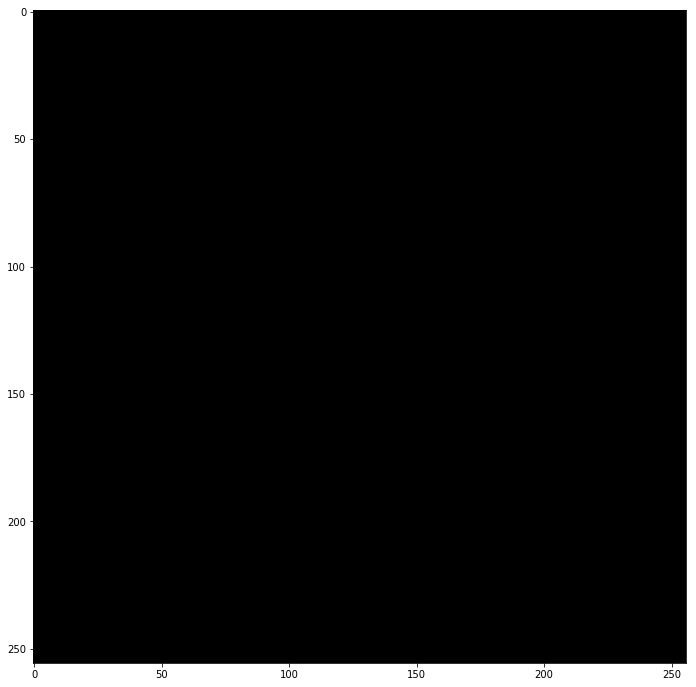

In [44]:
stiched_image = stitch_images(img_ref, img, max_tries=100000)
plt.figure(figsize=(18, 12))
plt.imshow(stiched_image, cmap='gray')